# Import needed libraries

In [5]:
# import system libs 
import os
import time
import shutil
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


### Read data

In [6]:
data_dir = '/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


# **Data Preprocessing**

### Split data and labels

In [7]:
Label = data["label"]
Data = data.drop(columns=["label"]) 

### Handling imbalanced datasets

In [8]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [9]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

### Convert abbreviations to it's words

In [10]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

### Splitting train and test

In [11]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [12]:
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')

X_train shape: (35201, 28, 28, 3)
X_test shape: (11734, 28, 28, 3)
y_train shape: (35201,)
y_test shape: (11734,)


### Convert labels to categorical types

In [13]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Create Image Data Generation

In [14]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

### Create ReduceLROnPlateau to learning rate reduction

In [15]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

# Model Structure

In [16]:
model = keras.models.Sequential()

# Create Model Structure
model.add(keras.layers.Input(shape=[28, 28, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          2

### Training model

In [18]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=25 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/25
276/276 [==============================] - 12s 14ms/step - loss: 1.3454 - accuracy: 0.5094 - val_loss: 1.2563 - val_accuracy: 0.5146
Epoch 2/25
276/276 [==============================] - 3s 11ms/step - loss: 0.6280 - accuracy: 0.7837 - val_loss: 0.4467 - val_accuracy: 0.8480
Epoch 3/25
276/276 [==============================] - 3s 11ms/step - loss: 0.3781 - accuracy: 0.8684 - val_loss: 0.2633 - val_accuracy: 0.9066
Epoch 4/25
276/276 [==============================] - 3s 11ms/step - loss: 0.2554 - accuracy: 0.9116 - val_loss: 0.1913 - val_accuracy: 0.9348
Epoch 5/25
276/276 [==============================] - 3s 11ms/step - loss: 0.1842 - accuracy: 0.9363 - val_loss: 0.2060 - val_accuracy: 0.9305
Epoch 6/25
276/276 [==============================] - 3s 11ms/step - loss: 0.1335 - accuracy: 0.9538 - val_loss: 0.2664 - val_accuracy: 0.9115

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/25
276/276 [==============================] - 3s 11m

### Show training history

In [19]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

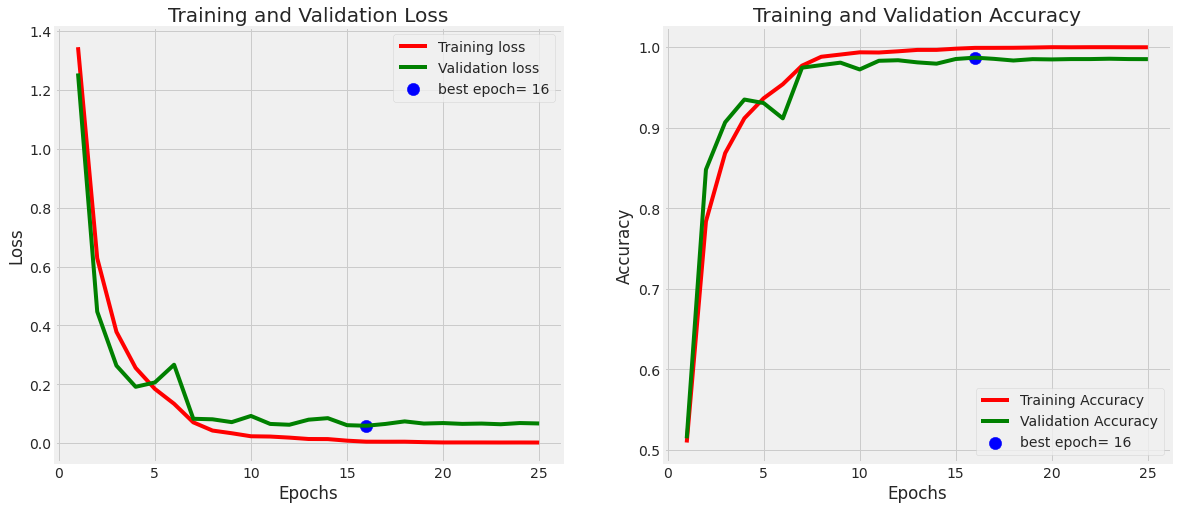

In [20]:
plot_training(history)

# Model Evaluation

In [21]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 1s 4ms/step - loss: 0.0667 - accuracy: 0.9849
Train Loss:  0.0003817540709860623
Train Accuracy:  0.9999147653579712
--------------------
Test Loss:  0.06667026877403259
Test Accuracy:  0.9849156141281128


In [22]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

In [23]:
y_true

array([4, 0, 6, ..., 6, 5, 2])

### Create classes labels

In [24]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


In [25]:
#Save the model
model.save('Skin_Cancer.h5')

In [1]:
# # ... (previous code for training)


# # Function for prediction
# from keras.models import load_model
# from keras.preprocessing import image
# import numpy as np

# def predict_image(model_path, image_path):
#     # Load the trained model
#     model = load_model(model_path)

#     # Load and preprocess the input image
#     img = image.load_img(image_path, target_size=(28, 28))
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array /= 255.0  # Rescale to the range [0, 1]

#     # Make the prediction
#     prediction = model.predict(img_array)

#     # Get the class index with the highest probability
#     predicted_class_index = np.argmax(prediction)

#     # You may want to have a mapping of class indices to class labels
#     class_labels = {0: 'class_0', 1: 'class_1', 2: 'class_2',3: 'class_3', 4: 'class_4', 5: 'class_5', 6: 'class_6'}

#     # Get the predicted class label
#     predicted_class_label = class_labels[predicted_class_index]

#     return predicted_class_label

# # Example usage of the prediction function
# image_path_to_predict = r"testing image\bcc\3.jpg"
# predicted_label = predict_image("Skin_Cancer.h5", image_path_to_predict)
# print(f"The predicted label for the provided image is: {predicted_label}")


# # """""Label 2 corresponds to lesion type: Benign keratosis-- bkl
# # Label 5 corresponds to lesion type: Melanocytic nevi--nv====
# # Label 3 corresponds to lesion type: Dermatofibroma --df
# # Label 4 corresponds to lesion type: Melanoma --mel=====
# # Label 6 corresponds to lesion type: Vascular lesions --vasc====
# # Label 1 corresponds to lesion type: Basal cell carcinoma --bcc
# # Label 0 corresponds to lesion type: Actinic keratoses--akiec

1/1 [==============================] - 0s 266ms/step
The predicted label for the provided image is: class_4


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

def predict_image_class(image_path):
    # Load the pre-trained EfficientNetB0 model
    model = load_model('effifix.hdf5')

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions =np.argmax(model.predict(img_array), axis=1)
    
    print(f"the image belongs to {[predictions[0]]}")

# Example usage
# image_path = r"testing image\bcc\3.jpg"
image_path = r"data\HAM10000_images_part_2\ISIC_0034011.jpg"
predict_image_class(image_path)

# """""Label 2 corresponds to lesion type: Benign keratosis-- bkl
# Label 5 corresponds to lesion type: Melanocytic nevi--nv====
# Label 3 corresponds to lesion type: Dermatofibroma --df
# Label 4 corresponds to lesion type: Melanoma --mel=====
# Label 6 corresponds to lesion type: Vascular lesions --vasc====
# Label 1 corresponds to lesion type: Basal cell carcinoma --bcc
# Label 0 corresponds to lesion type: Actinic keratoses--akiec


1/1 [==============================] - 1s 1s/step
the image belongs to [5]
